In [1]:
import jsonlines
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import csv

import pymorphy2
import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


**Перегон датасета jsonl ---> csv:**

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
with open('data.csv', mode='w', encoding="utf-8") as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    with jsonlines.open("data.jsonl") as json:
        z=0
        i=1
        for item in json:
            word_map={}
            sentense_to_tag={}
            word_to_tag={}
            j=1
            list=[]
            for annotation in item['annotations']:
                word_map['word_'+ str(j)] = item['content'][int(annotation['span']['start']):int(annotation['span']['end'])]
                word_to_tag[annotation['text']] = annotation['type']
                j+=1
            sentense_to_tag['Sentence ' + str(i)] = word_to_tag

            item['content'] = re.sub("\s\s+", ' ', re.sub('[0-9]', ' ', re.sub('[,.—?!)(«»]', '', item ['content'])))

            for mapped, word in word_map.items():
                item['content'] = item['content'].replace(word, mapped, 1)

            content_to_list = item['content'].split(" ")
            words =  [ word_map.get(x) if word_map.get(x)!=None else x for x in content_to_list]

            content = ' '.join(words)
            for word in words:
                tag = sentense_to_tag.get('Sentence '+ str(i)).get(word, 'O')
                writer.writerow(['Sentence:' + str(i), word, morph.parse(word)[0].tag.POS, tag])
            i+=1

**Читаем созданный csv пандасом:**

In [27]:
df = pd.read_csv("data.csv", header=None, names=['Sentence','Word','Pos','Tag'], nrows=1_000_000)
df.head(n=10)

,Sentence,Word,Pos,Tag
0,Sentence:1,Вице-премьер,NOUN,O
1,Sentence:1,по,PREP,O
2,Sentence:1,социальным,ADJF,O
3,Sentence:1,вопросам,NOUN,O
4,Sentence:1,Татьяна Голикова,NOUN,PER
5,Sentence:1,рассказала,VERB,O
6,Sentence:1,в,PREP,O
7,Sentence:1,каких,ADJF,O
8,Sentence:1,регионах,NOUN,O
9,Sentence:1,России,NOUN,LOC


In [28]:
words = [*set(df['Word'].values)]
tags = [*set(df['Tag'].values)]
n_words = len(words)
n_tags = len(tags)

print(f'Кол-во предложений в датасете: {len(df.groupby(["Sentence"]))}')
print(f'Кол-во слов в датасете: {n_words}')
print(f'Теги: {tags}')

Кол-во предложений в датасете: 5956
Кол-во слов в датасете: 113411
Теги: ['ORG', 'PER', 'LOC', 'O']


In [29]:
zip_function = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["Pos"].values.tolist(),
                                                           s["Tag"].values.tolist())]

In [30]:
grouped_df = df.groupby("Sentence").apply(zip_function)

In [31]:
grouped_df['Sentence:2']

[('Австрийские', 'ADJF', 'O'),
 ('правоохранительные', 'ADJF', 'O'),
 ('органы', 'NOUN', 'O'),
 ('не', 'PRCL', 'O'),
 ('представили', 'VERB', 'O'),
 ('доказательств', 'NOUN', 'O'),
 ('нарушения', 'NOUN', 'O'),
 ('российскими', 'ADJF', 'O'),
 ('биатлонистами', 'NOUN', 'O'),
 ('антидопинговых', 'ADJF', 'O'),
 ('правил', 'NOUN', 'O'),
 ('Об', 'PREP', 'O'),
 ('этом', 'NPRO', 'O'),
 ('сообщил', 'VERB', 'O'),
 ('посол', 'NOUN', 'O'),
 ('России', 'NOUN', 'LOC'),
 ('в', 'PREP', 'O'),
 ('Вене', 'NOUN', 'LOC'),
 ('Дмитрий Любинский', 'ADJF', 'PER'),
 ('по', 'PREP', 'O'),
 ('итогам', 'NOUN', 'O'),
 ('встречи', 'NOUN', 'O'),
 ('уполномоченного', 'ADJF', 'O'),
 ('адвоката', 'NOUN', 'O'),
 ('дипмиссии', 'NOUN', 'O'),
 ('с', 'PREP', 'O'),
 ('представителями', 'NOUN', 'O'),
 ('прокуратуры', 'NOUN', 'O'),
 ('страны', 'NOUN', 'O'),
 ('передает', 'VERB', 'O'),
 ('ТАСС', 'NOUN', 'ORG'),
 ('Действует', 'VERB', 'O'),
 ('презумпция', 'NOUN', 'O'),
 ('невиновности', 'NOUN', 'O'),
 ('Каких-либо', 'ADJF', 'O'),

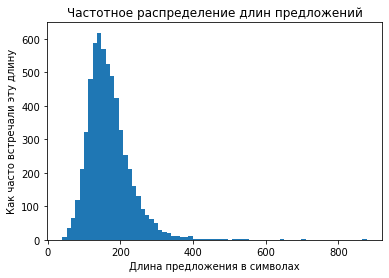

In [32]:
plt.hist([len(s) for s in grouped_df], bins=70)
plt.title('Частотное распределение длин предложений')
plt.xlabel('Длина предложения в символах')
plt.ylabel('Как часто встречали эту длину')
plt.show()

In [33]:
BATCH_SIZE = 32 # кол-во примеров используемых на каждой итерации
EPOCHS = 5
MAX_LEN = 75 # максимальная длина предложения
EMBEDDING = 20 # размерность ембеддинг вектора

**Процессим текст:**
1) замаппим слова на id.

2) замаппим теги на id.

3) для использования LSTM все предложения должны быть одинаковой длины. Юзаем для этого keras.preprocessing.sequence: те, что длиннее - усекаем; те, что короче - дополняем

In [34]:
word2id = {w: i + 2 for i, w in enumerate(words)}
word2id["UNK"] = 1
word2id["PAD"] = 0
id2word = {i: w for w, i in word2id.items()}

tag2id = {t: i+1 for i, t in enumerate(tags)}
tag2id["PAD"] = 0
id2tag = {i: w for w, i in tag2id.items()}

In [35]:
print("Россия <-> {}".format(word2id["Россия"]))
print("ORG <-> {}".format(tag2id["ORG"]))

Россия <-> 59517
ORG <-> 1


In [36]:
# Переписываем предложения через замапленные индексы:
X = [[word2id[w[0]] for w in s] for s in grouped_df]
print(f'{X[0]}\n <=============> \n {[id2word[x] for x in X[0]]} \n')

# Переписываем теги предложения через замапленные индексы:
y = [[tag2id[w[2]] for w in s] for s in grouped_df]
print(f'{y[0]}\n <=============> \n {[id2tag[y] for y in y[0]]} \n')

[41415, 69841, 132, 96300, 52651, 69117, 13268, 47387, 103599, 25521, 52293, 20014, 40820, 28726, 69805, 110855, 93885, 112229, 77793, 14600, 53488, 100845, 51303, 80790, 3911, 27327, 101352, 108599, 13268, 74031, 31604, 58623, 83613, 59697, 41950, 77829, 13268, 62448, 41415, 85153, 74544, 91068, 109152, 34169, 13268, 25521, 66234, 83613, 7320, 77678, 16549, 22559, 72584, 27138, 44677, 5625, 74544, 28726, 69805, 88407, 76331, 46543, 86120, 1646, 4792, 47221, 1085, 27138, 77793, 41276, 43874, 13268, 97433, 69805, 110855, 61414, 55786, 65945, 66157, 19304, 30819, 82669, 64419, 112420, 78580]
 <=============> 
 ['Вице-премьер', 'по', 'социальным', 'вопросам', 'Татьяна Голикова', 'рассказала', 'в', 'каких', 'регионах', 'России', 'зафиксирована', 'наиболее', 'высокая', 'смертность', 'от', 'рака', 'сообщает', 'РИА Новости', 'По', 'словам', 'Голиковой', 'чаще', 'всего', 'онкологические', 'заболевания', 'становились', 'причиной', 'смерти', 'в', 'Псковской', 'Тверской', 'Тульской', 'и', 'Орловс

In [37]:
# Приводим к одной длине:
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2id["PAD"])
print(f'{X[10]}\n ====================================>: \n {[id2word[x] for x in X[10]]} \n')

y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2id["PAD"])
print(f'{y[10]}\n ====================================>: \n {[id2tag[y] for y in y[10]]} \n')

[ 67676  22559  92323  13268   4748  33555  74544  78707  60998  83613
  77251  28450  89317  87418  93750  87715  83613  34736  83613  58004
  14174  13268  59352  93750  11023 100852 109209  67323  37771    493
  43145  19304  56467  93860  45856  19591  67323  52301  83613  11811
 100123  30040 109930 101525  57441  80158  24123  74544  57157  53561
  29904  39293  18641  70429  61126  70871  22807  21014 108113  10651
  32868  88940  41950  30040  89826 104223 111177  56449  47221   1035
  57898  25516  83613  61968  59607]
 ====================================>: 
 ['деятельности', 'В', 'методичке', 'в', 'частности', 'говорится', 'что', 'к', 'людям', 'и', 'их', 'проблемам', 'следует', 'относиться', 'с', 'уважением', 'и', 'вниманием', 'и', 'не', 'допускать', 'в', 'общении', 'с', 'ними', 'унижающих', 'достоинство', 'высказываний', 'Этические', 'нормы', 'приняты', 'на', 'фоне', 'многочисленных', 'скандалов', 'из-за', 'высказываний', 'чиновников', 'и', 'парламентариев', 'Например', 'де

In [38]:
from keras.utils import to_categorical
# One-Hot encode:
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

In [39]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [40]:
keras.backend.clear_session()

In [41]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, input_length=MAX_LEN)(input)
model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(n_tags+1)
out = crf(model)

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

C:\Users\gleb3\AppData\Local\Programs\Python\Python37\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\gleb3\AppData\Local\Programs\Python\Python37\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            2268260   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 5)             290       
Total params: 2,302,000
Trainable params: 2,302,000
Non-trainable params: 0
_________________________________________________________________


In [42]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10633521143372068147,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3059430196
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14918967514271884954
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [43]:
tf.debugging.set_log_device_placement(True)

In [44]:
history = model.fit(np.array(X_tr), np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=1)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5

Train on 4824 samples, validate on 536 samples
Epoch 1/5
4824/4824 [==============================] - 59s 12ms/step - loss: 0.4454 - crf_viterbi_accuracy: 0.8922 - val_loss: 0.3243 - val_crf_viterbi_accuracy: 0.9239
Epoch 2/5
4824/4824 [==============================] - 58s 12ms/step - loss: 0.2382 - crf_viterbi_accuracy: 0.9350 - val_loss: 0.1756 - val_crf_viterbi_accuracy: 0.9450
Epoch 3/5
4824/4824 [==============================] - 58s 12ms/step - loss: 0.1317 - crf_viterbi_accuracy: 0.9514 - val_loss: 0.1429 - val_crf_viterbi_accuracy: 0.9509
Epoch 4/5
4824/4824 [==============================] - 55s 11ms/step - loss: 0.0840 - crf_viterbi_accuracy: 0.9669 - val_loss: 0.1249 - val_crf_viterbi_accuracy: 0.9587
Epoch 5/5
4824/4824 [==============================] - 54s 11ms/step - loss: 0.0575 - crf_viterbi_accu

In [45]:
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [46]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[id2tag[i] for i in row] for row in pred]
y_te_true_tag = [[id2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

C:\Users\gleb3\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


              precision    recall  f1-score   support

         LOC       0.89      0.77      0.82      1524
           O       0.99      0.95      0.97     41017
         ORG       0.54      0.52      0.53       922
         PAD       0.99      1.00      1.00       143
         PER       0.24      0.62      0.34      1094

    accuracy                           0.93     44700
   macro avg       0.73      0.77      0.73     44700
weighted avg       0.96      0.93      0.94     44700



In [47]:
from ipywidgets import interact_manual
from ipywidgets import widgets

import re
import string

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
    
def get_prediction(sentence):
    test_sentence = tokenize(sentence) # Tokenization
    x_test_sent = pad_sequences(sequences=[[word2id.get(w, 0) for w in test_sentence]],
                                padding="post", value=word2id["PAD"], maxlen=MAX_LEN)
    p = model.predict(np.array([x_test_sent[0]]))
    p = np.argmax(p, axis=-1)
    print("{:15}||{}".format("Слово", " Предсказание"))
    print(30 * "=")
    for w, pred in zip(test_sentence, p[0]):
        print("{:15}: {:5}".format(w, id2tag[pred]))
        
interact_manual(get_prediction, sentence=widgets.Textarea(placeholder='Предложение'));

interactive(children=(Textarea(value='', description='sentence', placeholder='Предложение'), Button(descriptio…